### 1. Load libraries and functions

In [260]:
import os, re, json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy.stats import sem, t, ttest_1samp
import importlib
import modeleval
import avg_ensemble
from lifelines import KaplanMeierFitter
importlib.reload(modeleval)
importlib.reload(avg_ensemble)

# Import specific functions from custom modules to keep code clean and readable
from modeleval import (
    dh_test_model, nam_dagostino_chi2, get_baseline_hazard_at_timepoints, combined_test_model, evaluate_cif_predictions, calculate_null_brier, calculate_null_brier_series
)
from avg_ensemble import (
    load_bootstrap_predictions, generate_combinations, get_cif_for_combination, ensemble_cif_arrays, save_metrics_to_individual_json,
    get_processed_combinations, process_combination, process_combination_worker
)

def load_metrics_to_dataframe(output_dir):
    """
    Load all JSON metrics from the specified directory and organize them into a Pandas DataFrame.

    Args:
        output_dir (str): Directory containing JSON files.

    Returns:
        pd.DataFrame: DataFrame containing all metrics, sorted by combinations.
    """
    metrics_list = []

    # Iterate over all JSON files in the directory
    for file_name in os.listdir(output_dir):
        if file_name.endswith(".json"):  # Only process JSON files
            file_path = os.path.join(output_dir, file_name)
            with open(file_path, "r") as infile:
                try:
                    # Load the JSON data
                    data = json.load(infile)
                    for combo, metrics in data.items():
                        metrics_list.append({
                            "Bootstrap": file_name,
                            "Combination": combo,
                            **metrics
                        })
                except json.JSONDecodeError as e:
                    print(f"Error decoding {file_path}: {e}")

    # Convert the list of metrics to a DataFrame
    metrics_df = pd.DataFrame(metrics_list)

    # Sort the DataFrame by combination
    metrics_df = metrics_df.sort_values(by="Combination").reset_index(drop=True)

    print(f"Loaded metrics from {len(metrics_df)} combinations.")
    return metrics_df

def separate_event_metrics(df):
    """
    Separate and expand metrics for Event_1 and Event_2 into distinct columns.

    Args:
        df (pd.DataFrame): Original DataFrame containing nested metrics for events.

    Returns:
        pd.DataFrame: Updated DataFrame with separate columns for Event_1 and Event_2 metrics.
    """
    # Initialize lists to store separated data
    event_1_data = []
    event_2_data = []

    for idx, row in df.iterrows():
        # Extract Nam-Dagostino results for Event_1 and Event_2
        nam_dagostino_event_1 = [item for item in row["nam_dagostino_results"] if item["Event"] == 1]
        nam_dagostino_event_2 = [item for item in row["nam_dagostino_results"] if item["Event"] == 2]

        # Extract nested metrics
        event_1_row = {
            "Bootstrap": row["Bootstrap"],
            "Combination": row["Combination"],
            "Concordance_Index": row["concordance_indices"]["Event_1"],
            "Brier_series": row["brier_series"]["Event_1"],
            "Integrated_Brier_Score": row["integrated_brier_scores"]["Event_1"],
            "Neg_Log_Likelihood": row["neg_log_likelihoods"]["Event_1"],
            "Nam_Dagostino": nam_dagostino_event_1
        }
        event_2_row = {
            "Bootstrap": row["Bootstrap"],
            "Combination": row["Combination"],
            "Concordance_Index": row["concordance_indices"]["Event_2"],
            "Brier_series": row["brier_series"]["Event_1"],            
            "Integrated_Brier_Score": row["integrated_brier_scores"]["Event_2"],
            "Neg_Log_Likelihood": row["neg_log_likelihoods"]["Event_2"],
            "Nam_Dagostino": nam_dagostino_event_2
        }

        # Append separated rows
        event_1_data.append(event_1_row)
        event_2_data.append(event_2_row)

    # Create separate DataFrames for Event_1 and Event_2
    event_1_df = pd.DataFrame(event_1_data)
    event_1_df["Event"] = "Event_1"

    event_2_df = pd.DataFrame(event_2_data)
    event_2_df["Event"] = "Event_2"

    # Combine into a single DataFrame
    combined_df = pd.concat([event_1_df, event_2_df], axis=0).reset_index(drop=True)

    return combined_df

def sort_metrics_by_combination_length(df):
    """
    Sort metrics for Event_1 and Event_2 by the length of the combination (as tuples).

    Args:
        df (pd.DataFrame): Input DataFrame containing metrics with Combination as tuples.

    Returns:
        pd.DataFrame: Sorted DataFrame with an additional "Combination_Length" column.
    """
    # Ensure the Combination column contains tuples
    assert all(isinstance(combo, tuple) for combo in df["Combination"]), "Combination column must contain tuples."

    # Add a column for the length of combinations
    df["Combination_Length"] = df["Combination"].apply(len)

    # Sort by Combination_Length and Combination (optional for consistency)
    sorted_df = df.sort_values(by=["Combination_Length", "Combination"], ascending=True).reset_index(drop=True)

    return sorted_df

def calculate_statistics_per_combination_length(df):
    """
    Calculate the mean, 95% CI, and p-value for concordance index, integrated brier score, and negative log likelihood
    for Event_1 and Event_2, grouped by combination length.

    Args:
        df (pd.DataFrame): Input DataFrame containing metrics and combination lengths.

    Returns:
        pd.DataFrame: Summary statistics for each combination length and event.
    """
    results = []

    # Group by Combination_Length and Event
    grouped = df.groupby(["Combination_Length", "Event"])

    for (comb_length, event), group in grouped:
        stats = {
            "Combination_Length": comb_length,
            "Event": event,
        }

        # Calculate statistics for each metric
        for metric in ["Concordance_Index", "Integrated_Brier_Score", "Neg_Log_Likelihood", "ira", "IRA_1_year", "IRA_2_year", "IRA_3_year", "IRA_4_year", "IRA_5_year"]:
            values = group[metric].values
            mean = np.mean(values)
            std_err = sem(values)  # Standard error
            ci_low, ci_high = t.interval(0.95, len(values) - 1, loc=mean, scale=std_err)  # 95% CI
            
            # Perform a one-sample t-test against 0.5 as an example (adjust as needed)
            t_stat, p_value = ttest_1samp(values, 0.5)
            
            stats[f"{metric}_Mean"] = mean
            stats[f"{metric}_CI_Low"] = ci_low
            stats[f"{metric}_CI_High"] = ci_high
            stats[f"{metric}_P_Value"] = p_value       
        
        results.append(stats)

    return pd.DataFrame(results)

def plot_metric_vs_combination_length(df, metric_name, event_col="Event"):
    """
    Generalized function to plot a specified metric against combination length.
    
    Args:
        df (pd.DataFrame): DataFrame containing metrics for combinations of models.
        metric_name (str): The base name of the metric to plot (e.g., "Concordance_Index").
        event_col (str): The column representing the event type (default is "Event").
    
    Returns:
        None: Displays the plot.
    """
    # Ensure the metric columns exist
    metric_mean_col = f"{metric_name}_Mean"
    metric_ci_low_col = f"{metric_name}_CI_Low"
    metric_ci_high_col = f"{metric_name}_CI_High"
    
    if not all(col in df.columns for col in [metric_mean_col, metric_ci_low_col, metric_ci_high_col, event_col]):
        raise ValueError(f"One or more required columns for '{metric_name}' are missing in the DataFrame.")
    
    # Plot for each event
    unique_events = df[event_col].unique()
    plt.figure(figsize=(10, 6))
    
    for event in unique_events:
        event_data = df[df[event_col] == event]
        combination_lengths = event_data["Combination_Length"]
        metric_means = event_data[metric_mean_col]
        ci_low = event_data[metric_ci_low_col]
        ci_high = event_data[metric_ci_high_col]
        
        # Plot mean and confidence interval
        plt.plot(combination_lengths, metric_means, label=f"{metric_name} (Event {event})")
        plt.fill_between(combination_lengths, ci_low, ci_high, alpha=0.2, label=f"95% CI (Event {event})")
    
    # Customize the plot
    plt.title(f"{metric_name} vs. Number of Model Predictions Ensembled")
    plt.xlabel("Number of Model Predictions Ensembled")
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(False)
    plt.show()

def reshape_brier_scores(metrics_df):
    """
    Reshape the Brier scores into a flat structure with columns like 'event_1_year_0', 'event_2_year_1', etc.

    Args:
        metrics_df (pd.DataFrame): The input DataFrame containing metrics, including 'brier_series'.

    Returns:
        pd.DataFrame: A DataFrame where Brier scores are flattened into specific columns for each event and year.
    """
    # Ensure the Combination column contains tuples
    assert all(isinstance(combo, tuple) for combo in metrics_df["Combination"]), "Combination column must contain tuples."

    # Add a column for the length of combinations
    metrics_df["Combination_Length"] = metrics_df["Combination"].apply(len)

    reshaped_data = []

    for idx, row in metrics_df.iterrows():
        # Start with base row data
        reshaped_row = {
            "Bootstrap": row["Bootstrap"],
            "Combination": row["Combination"],
            "Combination_Length": row["Combination_Length"]
        }

        # Flatten Brier scores
        brier_series = row["brier_series"]
        for event, scores in brier_series.items():  # Iterate over Event_1 and Event_2
            for year, score in enumerate(scores):  # Iterate over years (0, 1, 2, 3, 4, 5)
                column_name = f"{event.lower()}_year_{year}"
                reshaped_row[column_name] = score

        reshaped_data.append(reshaped_row)

    return pd.DataFrame(reshaped_data)

def calculate_brier_statistics(reshaped_brier_df):
    """
    Calculate the mean, 95% CI, and p-value for Brier scores for each combination length and time point.

    Args:
        reshaped_brier_df (pd.DataFrame): DataFrame with reshaped Brier scores.

    Returns:
        pd.DataFrame: DataFrame with aggregated statistics for each combination length and time point.
    """
    aggregated_data = []

    for combination_length in reshaped_brier_df["Combination_Length"].unique():
        subset = reshaped_brier_df[reshaped_brier_df["Combination_Length"] == combination_length]

        for event in ["event_1", "event_2"]:
            for year in range(6):  # Assuming 6 years
                column_name = f"{event}_year_{year}"
                values = subset[column_name].dropna()

                if len(values) > 1:
                    mean = values.mean()
                    std_err = values.std(ddof=1) / np.sqrt(len(values))
                    ci_low, ci_high = t.interval(0.95, len(values) - 1, loc=mean, scale=std_err)
                    t_stat, p_value = ttest_1samp(values, 0.0)
                else:
                    mean, ci_low, ci_high, p_value = [np.nan] * 4

                aggregated_data.append({
                    "Combination_Length": combination_length,
                    "Event": event,
                    "Time_Point": year,
                    "Brier_Mean": mean,
                    "Brier_CI_Low": ci_low,
                    "Brier_CI_High": ci_high,
                    "P_Value": p_value
                })

    return pd.DataFrame(aggregated_data)

def plot_brier_scores(brier_stats_df):
    """
    Plot the Brier scores for different combination lengths and events.

    Args:
        brier_stats_df (pd.DataFrame): DataFrame with Brier score statistics.
    """
    for event in ["event_1", "event_2"]:
        event_data = brier_stats_df[brier_stats_df["Event"] == event]
        plt.figure(figsize=(10, 6))
        for combination_length in event_data["Combination_Length"].unique():
            subset = event_data[event_data["Combination_Length"] == combination_length]
            plt.plot(
                subset["Time_Point"],
                subset["Brier_Mean"],
                label=f"Combination Length {combination_length}"
            )
            plt.fill_between(
                subset["Time_Point"],
                subset["Brier_CI_Low"],
                subset["Brier_CI_High"],
                alpha=0.2
            )

        plt.title(f"Brier Scores for {event.replace('_', ' ').title()}")
        plt.xlabel("Time Point")
        plt.ylabel("Brier Score")
        plt.legend()
        plt.grid(True)
        plt.show()

### 2. Calculate the Brier score of null model for each bootstrap

In [142]:

# Directory containing the bootstrap HDF5 files
directory_path = '/mnt/d/PYDataScience/g3_regress/data/results/bootstrap_predictions/20241130/'
output_dir = "/mnt/d/PYDataScience/g3_regress/data/results/full_ensemble"

# Load all bootstrap predictions
bootstrap_data = load_bootstrap_predictions(directory_path)

predictions = bootstrap_data["predictions"]
durations = bootstrap_data["durations"]
events = bootstrap_data["events"]
time_grid = np.array([0, 1, 2, 3, 4, 5])
null_brier_scores = {}
null_brier_series = {}
prediction_keys = list(predictions.keys())

for i, itr_predictions in enumerate(predictions.values()):
    current_key = prediction_keys[i]    
    print(f"Processing key: {current_key}")    
    itr_durations = durations[i]
    itr_events = events[i]
    
    # Calculate null Brier score for this bootstrap iteration
    null_brier_score = calculate_null_brier(itr_durations, itr_events, time_grid)
    null_brier_scores[current_key] = null_brier_score
    null_brier_serie = calculate_null_brier_series(itr_durations, itr_events, time_grid) 
    null_brier_series[current_key] = null_brier_serie
    
    print(f"Bootstrap {i+1}: Integrated Null Brier Score = {null_brier_score}")

Loading /mnt/d/PYDataScience/g3_regress/data/results/bootstrap_predictions/20241130/bootstrap_iteration_1.h5...
Loading /mnt/d/PYDataScience/g3_regress/data/results/bootstrap_predictions/20241130/bootstrap_iteration_10.h5...
Loading /mnt/d/PYDataScience/g3_regress/data/results/bootstrap_predictions/20241130/bootstrap_iteration_100.h5...
Loading /mnt/d/PYDataScience/g3_regress/data/results/bootstrap_predictions/20241130/bootstrap_iteration_101.h5...
Loading /mnt/d/PYDataScience/g3_regress/data/results/bootstrap_predictions/20241130/bootstrap_iteration_102.h5...
Loading /mnt/d/PYDataScience/g3_regress/data/results/bootstrap_predictions/20241130/bootstrap_iteration_103.h5...
Loading /mnt/d/PYDataScience/g3_regress/data/results/bootstrap_predictions/20241130/bootstrap_iteration_104.h5...
Loading /mnt/d/PYDataScience/g3_regress/data/results/bootstrap_predictions/20241130/bootstrap_iteration_105.h5...
Loading /mnt/d/PYDataScience/g3_regress/data/results/bootstrap_predictions/20241130/bootstr

/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(


Calculating null Brier scores for Event_2...


/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(


Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...


/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(


Calculating null Brier scores for Event_2...


/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(


Bootstrap 3: Integrated Null Brier Score = {1: 0.07871045312302417, 2: 0.09323051881266134}
Processing key: 101
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Bootstrap 4: Integrated Null Brier Score = {1: 0.05985476890747403, 2: 0.08604777724318272}
Processing key: 102
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Bootstrap 5: Integrated Null Brier Score = {1: 0.05953871538254415, 2: 0.08898374804288758}
Processing key: 103
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for 

/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(


Calculating null Brier scores for Event_2...


/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(


Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...


/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(


Calculating null Brier scores for Event_2...


/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(


Bootstrap 105: Integrated Null Brier Score = {1: 0.08398583306528612, 2: 0.08590930680281125}
Processing key: 194
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Bootstrap 106: Integrated Null Brier Score = {1: 0.06778723162634208, 2: 0.08745863817273374}
Processing key: 195
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Bootstrap 107: Integrated Null Brier Score = {1: 0.06359017364349637, 2: 0.08573206442027229}
Processing key: 196
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier score

/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(


Calculating null Brier scores for Event_2...


/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(


Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...


/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(


Calculating null Brier scores for Event_2...


/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(


Bootstrap 121: Integrated Null Brier Score = {1: 0.08222822949339556, 2: 0.1035905288972609}
Processing key: 208
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Bootstrap 122: Integrated Null Brier Score = {1: 0.07822699235788835, 2: 0.09013472462302834}
Processing key: 209
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Bootstrap 123: Integrated Null Brier Score = {1: 0.06221369744241547, 2: 0.09406782840816205}
Processing key: 21
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores 

/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(


Calculating null Brier scores for Event_2...


/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(


Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...


/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(


Calculating null Brier scores for Event_2...


/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(


Bootstrap 246: Integrated Null Brier Score = {1: 0.07748801236645313, 2: 0.08776362343909391}
Processing key: 320
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Bootstrap 247: Integrated Null Brier Score = {1: 0.07575143983958713, 2: 0.09226609839282082}
Processing key: 321
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Bootstrap 248: Integrated Null Brier Score = {1: 0.07009836628334166, 2: 0.08588168423349751}
Processing key: 322
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier score

/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(


Calculating null Brier scores for Event_2...


/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(


Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...


/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(


Calculating null Brier scores for Event_2...


/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(


Bootstrap 257: Integrated Null Brier Score = {1: 0.07931348281561842, 2: 0.08513413408112694}
Processing key: 330
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Bootstrap 258: Integrated Null Brier Score = {1: 0.08274513260132664, 2: 0.0874767031457569}
Processing key: 331
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Bootstrap 259: Integrated Null Brier Score = {1: 0.06287294868684275, 2: 0.09010654646769185}
Processing key: 332
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores

/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(


Calculating null Brier scores for Event_2...


/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(


Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...


/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(


Calculating null Brier scores for Event_2...


/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(


Bootstrap 261: Integrated Null Brier Score = {1: 0.07959811234302128, 2: 0.0816263033651938}
Processing key: 334
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Bootstrap 262: Integrated Null Brier Score = {1: 0.05767979784463293, 2: 0.08306705061666934}
Processing key: 335
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Bootstrap 263: Integrated Null Brier Score = {1: 0.060354690829223845, 2: 0.0902281608517779}
Processing key: 336
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores

/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(


Calculating null Brier scores for Event_2...


/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(


Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...


/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(


Calculating null Brier scores for Event_2...


/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(


Bootstrap 456: Integrated Null Brier Score = {1: 0.07573115244506141, 2: 0.08414779105965234}
Processing key: 6
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Bootstrap 457: Integrated Null Brier Score = {1: 0.06479502451138211, 2: 0.08219478243406333}
Processing key: 60
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Bootstrap 458: Integrated Null Brier Score = {1: 0.060889287538215986, 2: 0.09211112747461467}
Processing key: 61
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores f

/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(


Calculating null Brier scores for Event_2...


/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(


Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...


/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(


Calculating null Brier scores for Event_2...


/home/goma/miniconda3/envs/ai_dev/lib/python3.11/site-packages/lifelines/fitters/aalen_johansen_fitter.py:112: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(


Bootstrap 497: Integrated Null Brier Score = {1: 0.0820276384403669, 2: 0.0907611563642707}
Processing key: 97
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Bootstrap 498: Integrated Null Brier Score = {1: 0.06192550916422801, 2: 0.07564096203065898}
Processing key: 98
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Bootstrap 499: Integrated Null Brier Score = {1: 0.05665736533987973, 2: 0.10004783008623482}
Processing key: 99
Calculating null Brier scores for Event_1...
Calculating null Brier scores for Event_2...
Calculating null Brier scores for

In [143]:
null_brier_series_dict = {}
for key in null_brier_series.keys():
    null_brier_series_dict[key] = {}
    for e in null_brier_series[key].keys():
        null_brier_series_dict[key][e] = [s for s in null_brier_series[key][e]]

### 3. Load the outputs

In [144]:
output_dir = "/mnt/d/PYDataScience/g3_regress/data/results/avg_ensemble"

# Load metrics into a DataFrame
metrics_df = load_metrics_to_dataframe(output_dir)


Loaded metrics from 255500 combinations.


In [164]:
def map_null_brier(row, data):
    bootstrap_idx = row['Bootstrap_Index']
    event_num = int(row['Event'].split('_')[1])
    value = data.get([key for key in data.keys()][bootstrap_idx], {}).get(event_num, None)
    return value

def calculate_ira_for_all_years(row):
    brier_series = row['Brier_series']
    null_brier_series = row['Null_Brier_Series']
    # Calculate IRA for each year
    ira_series = {f"IRA_{i}_year": 1 - (brier / null_brier) if null_brier != 0 else None
                  for i, (brier, null_brier) in enumerate(zip(brier_series, null_brier_series))}
    # Convert to a pandas Series for compatibility
    return pd.Series(ira_series)

separated_metrics_df = separate_event_metrics(metrics_df)
separated_metrics_df["Combination"] = separated_metrics_df["Combination"].apply(
    lambda x: eval(x) if not isinstance(x, tuple) else x
)
separated_metrics_df['Bootstrap_Index'] = separated_metrics_df['Bootstrap'].apply(
    lambda x: re.search(r'bootstrap_(\d+)', x).group(1)
)
separated_metrics_df['Bootstrap_Index'] = separated_metrics_df['Bootstrap_Index'].values.astype(int)
separated_metrics_df['Null_Brier_Score'] = separated_metrics_df.apply(map_null_brier, axis=1, data=null_brier_scores)
separated_metrics_df['Null_Brier_Series'] = separated_metrics_df.apply(map_null_brier, axis=1, data=null_brier_series_dict)
separated_metrics_df.drop(columns=['Bootstrap_Index'], inplace=True)
separated_metrics_df['ira'] = 1 - separated_metrics_df['Integrated_Brier_Score']/separated_metrics_df['Null_Brier_Score']

ira_df = separated_metrics_df.apply(calculate_ira_for_all_years, axis=1)
separated_metrics_df = pd.concat([separated_metrics_df, ira_df], axis=1)


In [166]:
display(separated_metrics_df.head())


,Bootstrap,Combination,Concordance_Index,Brier_series,Integrated_Brier_Score,Neg_Log_Likelihood,Nam_Dagostino,Event,Null_Brier_Score,Null_Brier_Series,ira,IRA_0_year,IRA_1_year,IRA_2_year,IRA_3_year,IRA_4_year,IRA_5_year
0,bootstrap_480_combo_deephit_ann_NearMiss_deeph...,"(deephit_ann_NearMiss, deephit_lstm_NearMiss)",0.801588,"[1.7444291535273663e-07, 0.004052471457472855,...",0.063232,0.198066,"[{'Event': 1, 'Year': 0, 'Chi2_Stat': 0.002465...",Event_1,0.065274,"[0.0, 0.0040772554180472115, 0.009619512362397...",0.031294,NaN,0.006079,0.008069,0.021924,0.044236,0.028279
1,bootstrap_139_combo_deephit_ann_NearMiss_deeph...,"(deephit_ann_NearMiss, deephit_lstm_NearMiss)",0.793199,"[1.7540632901376021e-07, 0.004206145650225417,...",0.059995,0.189420,"[{'Event': 1, 'Year': 0, 'Chi2_Stat': 0.002425...",Event_1,0.060445,"[0.0, 0.004218325298925355, 0.0112842035416397...",0.007453,NaN,0.002887,0.013278,0.011982,0.034631,-0.003585
2,bootstrap_240_combo_deephit_ann_NearMiss_deeph...,"(deephit_ann_NearMiss, deephit_lstm_NearMiss)",0.768740,"[1.7905259148712516e-07, 0.0038163518466621197...",0.058778,0.186091,"[{'Event': 1, 'Year': 0, 'Chi2_Stat': 0.002478...",Event_1,0.063235,"[0.0, 0.003643073847798711, 0.0105716399849856...",0.070482,NaN,-0.047564,0.003522,0.021443,0.027517,0.096064
3,bootstrap_404_combo_deephit_ann_NearMiss_deeph...,"(deephit_ann_NearMiss, deephit_lstm_NearMiss)",0.821872,"[1.752574971201721e-07, 0.004074360622288316, ...",0.061160,0.192657,"[{'Event': 1, 'Year': 0, 'Chi2_Stat': 0.002451...",Event_1,0.063730,"[0.0, 0.004119799185425256, 0.0102712114582899...",0.040327,NaN,0.011029,0.005115,0.009847,0.034343,0.049037
4,bootstrap_341_combo_deephit_ann_NearMiss_deeph...,"(deephit_ann_NearMiss, deephit_lstm_NearMiss)",0.791780,"[1.7490001408988725e-07, 0.004016326465972433,...",0.057442,0.182430,"[{'Event': 1, 'Year': 0, 'Chi2_Stat': 0.002443...",Event_1,0.067683,"[0.0, 0.00394849683235344, 0.00918264892848863...",0.151310,NaN,-0.017179,0.006484,0.017081,0.011148,0.210077


In [167]:

# Sort the metrics by combination length
sorted_metrics_df = sort_metrics_by_combination_length(separated_metrics_df)

# Calculate statistics
summary_stats_df = calculate_statistics_per_combination_length(sorted_metrics_df)


### 4. Get the metrics of the full ensemble from the 9 models:

In [263]:
summary_stats_df.loc[summary_stats_df['Combination_Length'] == 9]

,Combination_Length,Event,Concordance_Index_Mean,Concordance_Index_CI_Low,Concordance_Index_CI_High,Concordance_Index_P_Value,Integrated_Brier_Score_Mean,Integrated_Brier_Score_CI_Low,Integrated_Brier_Score_CI_High,Integrated_Brier_Score_P_Value,...,IRA_3_year_CI_High,IRA_3_year_P_Value,IRA_4_year_Mean,IRA_4_year_CI_Low,IRA_4_year_CI_High,IRA_4_year_P_Value,IRA_5_year_Mean,IRA_5_year_CI_Low,IRA_5_year_CI_High,IRA_5_year_P_Value
16,9,Event_1,0.984393,0.984259,0.984527,0.0,0.036360,0.036037,0.036683,0.0,...,-0.176654,1.307357e-308,-0.521709,-0.550534,-0.492884,3.557506e-259,0.897305,0.895698,0.898911,0.000000e+00
17,9,Event_2,0.823128,0.822324,0.823932,0.0,0.090933,0.090489,0.091377,0.0,...,0.566988,6.263294e-75,0.611517,0.605937,0.617098,1.016101e-154,0.317000,0.287820,0.346180,1.212363e-30


In [238]:
cif_array_labels = [
    "deepsurv_ann_clustering",
    "deepsurv_ann_enn",
    "deepsurv_ann_tomek",
    "deepsurv_lstm_clustering",
    "deepsurv_lstm_NearMiss",
    "deephit_ann_clustering",
    "deephit_ann_NearMiss",
    "deephit_lstm_clustering",
    "deephit_lstm_NearMiss",
]

predictions = bootstrap_data["predictions"]
durations = bootstrap_data["durations"]
events = bootstrap_data["events"]
all_combinations = generate_combinations(cif_array_labels)
combo = [i for i in all_combinations if len(i) == 9]

data = {
    "Time Point": [],
    "event": [],
    "Quantile": [],
    "Predicted": [],
    "Observed": [],
    "Quantile Label": []
}

for i, itr_predictions in enumerate(predictions.values()):
    itr_durations = durations[i]
    itr_events = events[i]

    cif_array = get_cif_for_combination(itr_predictions, combo[0])
    ensembled_cif = ensemble_cif_arrays(cif_array)
    
    for e in range(ensembled_cif.shape[0]):
        for t in range(ensembled_cif.shape[1]):
            if np.isscalar(itr_durations):  # If scalar, wrap in a list
                itr_durations = [t for t in itr_durations]            
            assert len(itr_durations) == len(ensembled_cif[e][t]), \
                f"Length mismatch: {len(itr_durations)} durations vs {len(ensembled_cif[e][t])} predictions"
            prob_df = pd.DataFrame({
            'predicted_probs': ensembled_cif[e][t],
            'observed_probs': np.nan  # Placeholder for observed probabilities
            },
            index=pd.Index(itr_durations, name="Durations")            
            )            
        
            prob_df['quantile'], bin_edges = pd.qcut(prob_df['predicted_probs'], 10, retbins=True, labels=False, duplicates='drop')
            quantile_labels = [f"{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}" for i in range(len(bin_edges) - 1)]        
            prob_df['quantile'] = prob_df['quantile'].astype(int)
        
            observed_probs = []
            for q in prob_df['quantile'].unique():
                mask = prob_df['quantile'] == q
                durations_observed = pd.Series(itr_durations[mask]).astype(float)
                event_observed = pd.Series(itr_events[mask])

                kmf = KaplanMeierFitter()
                kmf.fit(durations=durations_observed, event_observed=event_observed)

                # Find closest time point
                if t not in kmf.cumulative_density_.index:
                    closest_idx = kmf.cumulative_density_.index.get_indexer([t], method='nearest')[0]
                    closest_time = kmf.cumulative_density_.index[closest_idx]
                else:
                    closest_time = t

                observed_probs.append(kmf.cumulative_density_.loc[closest_time].values[0])
            # Map observed probabilities back to quantiles
            prob_df['observed_probs'] = prob_df['quantile'].map(dict(zip(prob_df['quantile'].unique(), observed_probs)))        
            grouped = prob_df.groupby('quantile')
            observed_events = grouped['observed_probs'].mean()
            expected_events = grouped['predicted_probs'].mean()        
                # Append data to `data` dictionary
            for q in prob_df['quantile'].unique():
                data['event'].append(e+1)
                data['Time Point'].append(t)
                data['Quantile'].append(q)
                data['Quantile Label'].append(quantile_labels[q])            
                data['Predicted'].append(expected_events[q])
                data['Observed'].append(observed_events[q])        
            
        
risk_plot_df = pd.DataFrame(data)
risk_plot_df['Predicted'] *= 100
risk_plot_df['Observed'] *= 100
risk_plot_df.head()

,Time Point,event,Quantile,Predicted,Observed,Quantile Label
0,0,1,9,0.030493,0.0,0.00-0.00
1,0,1,6,0.017939,0.0,0.00-0.00
2,0,1,8,0.022393,0.0,0.00-0.00
3,0,1,2,0.012049,0.0,0.00-0.00
4,0,1,1,0.008951,0.0,0.00-0.00


In [239]:
def compute_mean_and_ci(data):
    mean = data.mean()
    lower_ci = mean - 1.96 * sem(data)
    upper_ci = mean + 1.96 * sem(data)
    return mean, lower_ci, upper_ci

aggregated_data = []
for event in risk_plot_df['event'].unique():
    for time_point in risk_plot_df['Time Point'].unique():
        event_data = risk_plot_df[(risk_plot_df['event'] == event) & (risk_plot_df['Time Point'] == time_point)]
        for quantile in range(10):  # Ensure all quantiles (0-9) are represented
            quantile_data = event_data[event_data['Quantile'] == quantile]
            quantile_label = event_data.loc[event_data['Quantile'] == quantile, ['Quantile Label']]['Quantile Label'].unique()
            if not quantile_data.empty:
                predicted_mean, predicted_lower, predicted_upper = compute_mean_and_ci(quantile_data['Predicted'])
                observed_mean, observed_lower, observed_upper = compute_mean_and_ci(quantile_data['Observed'])
                aggregated_data.append({
                    'Time Point': time_point,
                    'event': event,
                    'Quantile': quantile,
                    'quantile_label': quantile_label,
                    'Predicted Mean': predicted_mean,
                    'Predicted Lower CI': predicted_lower,
                    'Predicted Upper CI': predicted_upper,
                    'Observed Mean': observed_mean,
                    'Observed Lower CI': observed_lower,
                    'Observed Upper CI': observed_upper
                })
aggregated_df = pd.DataFrame(aggregated_data)


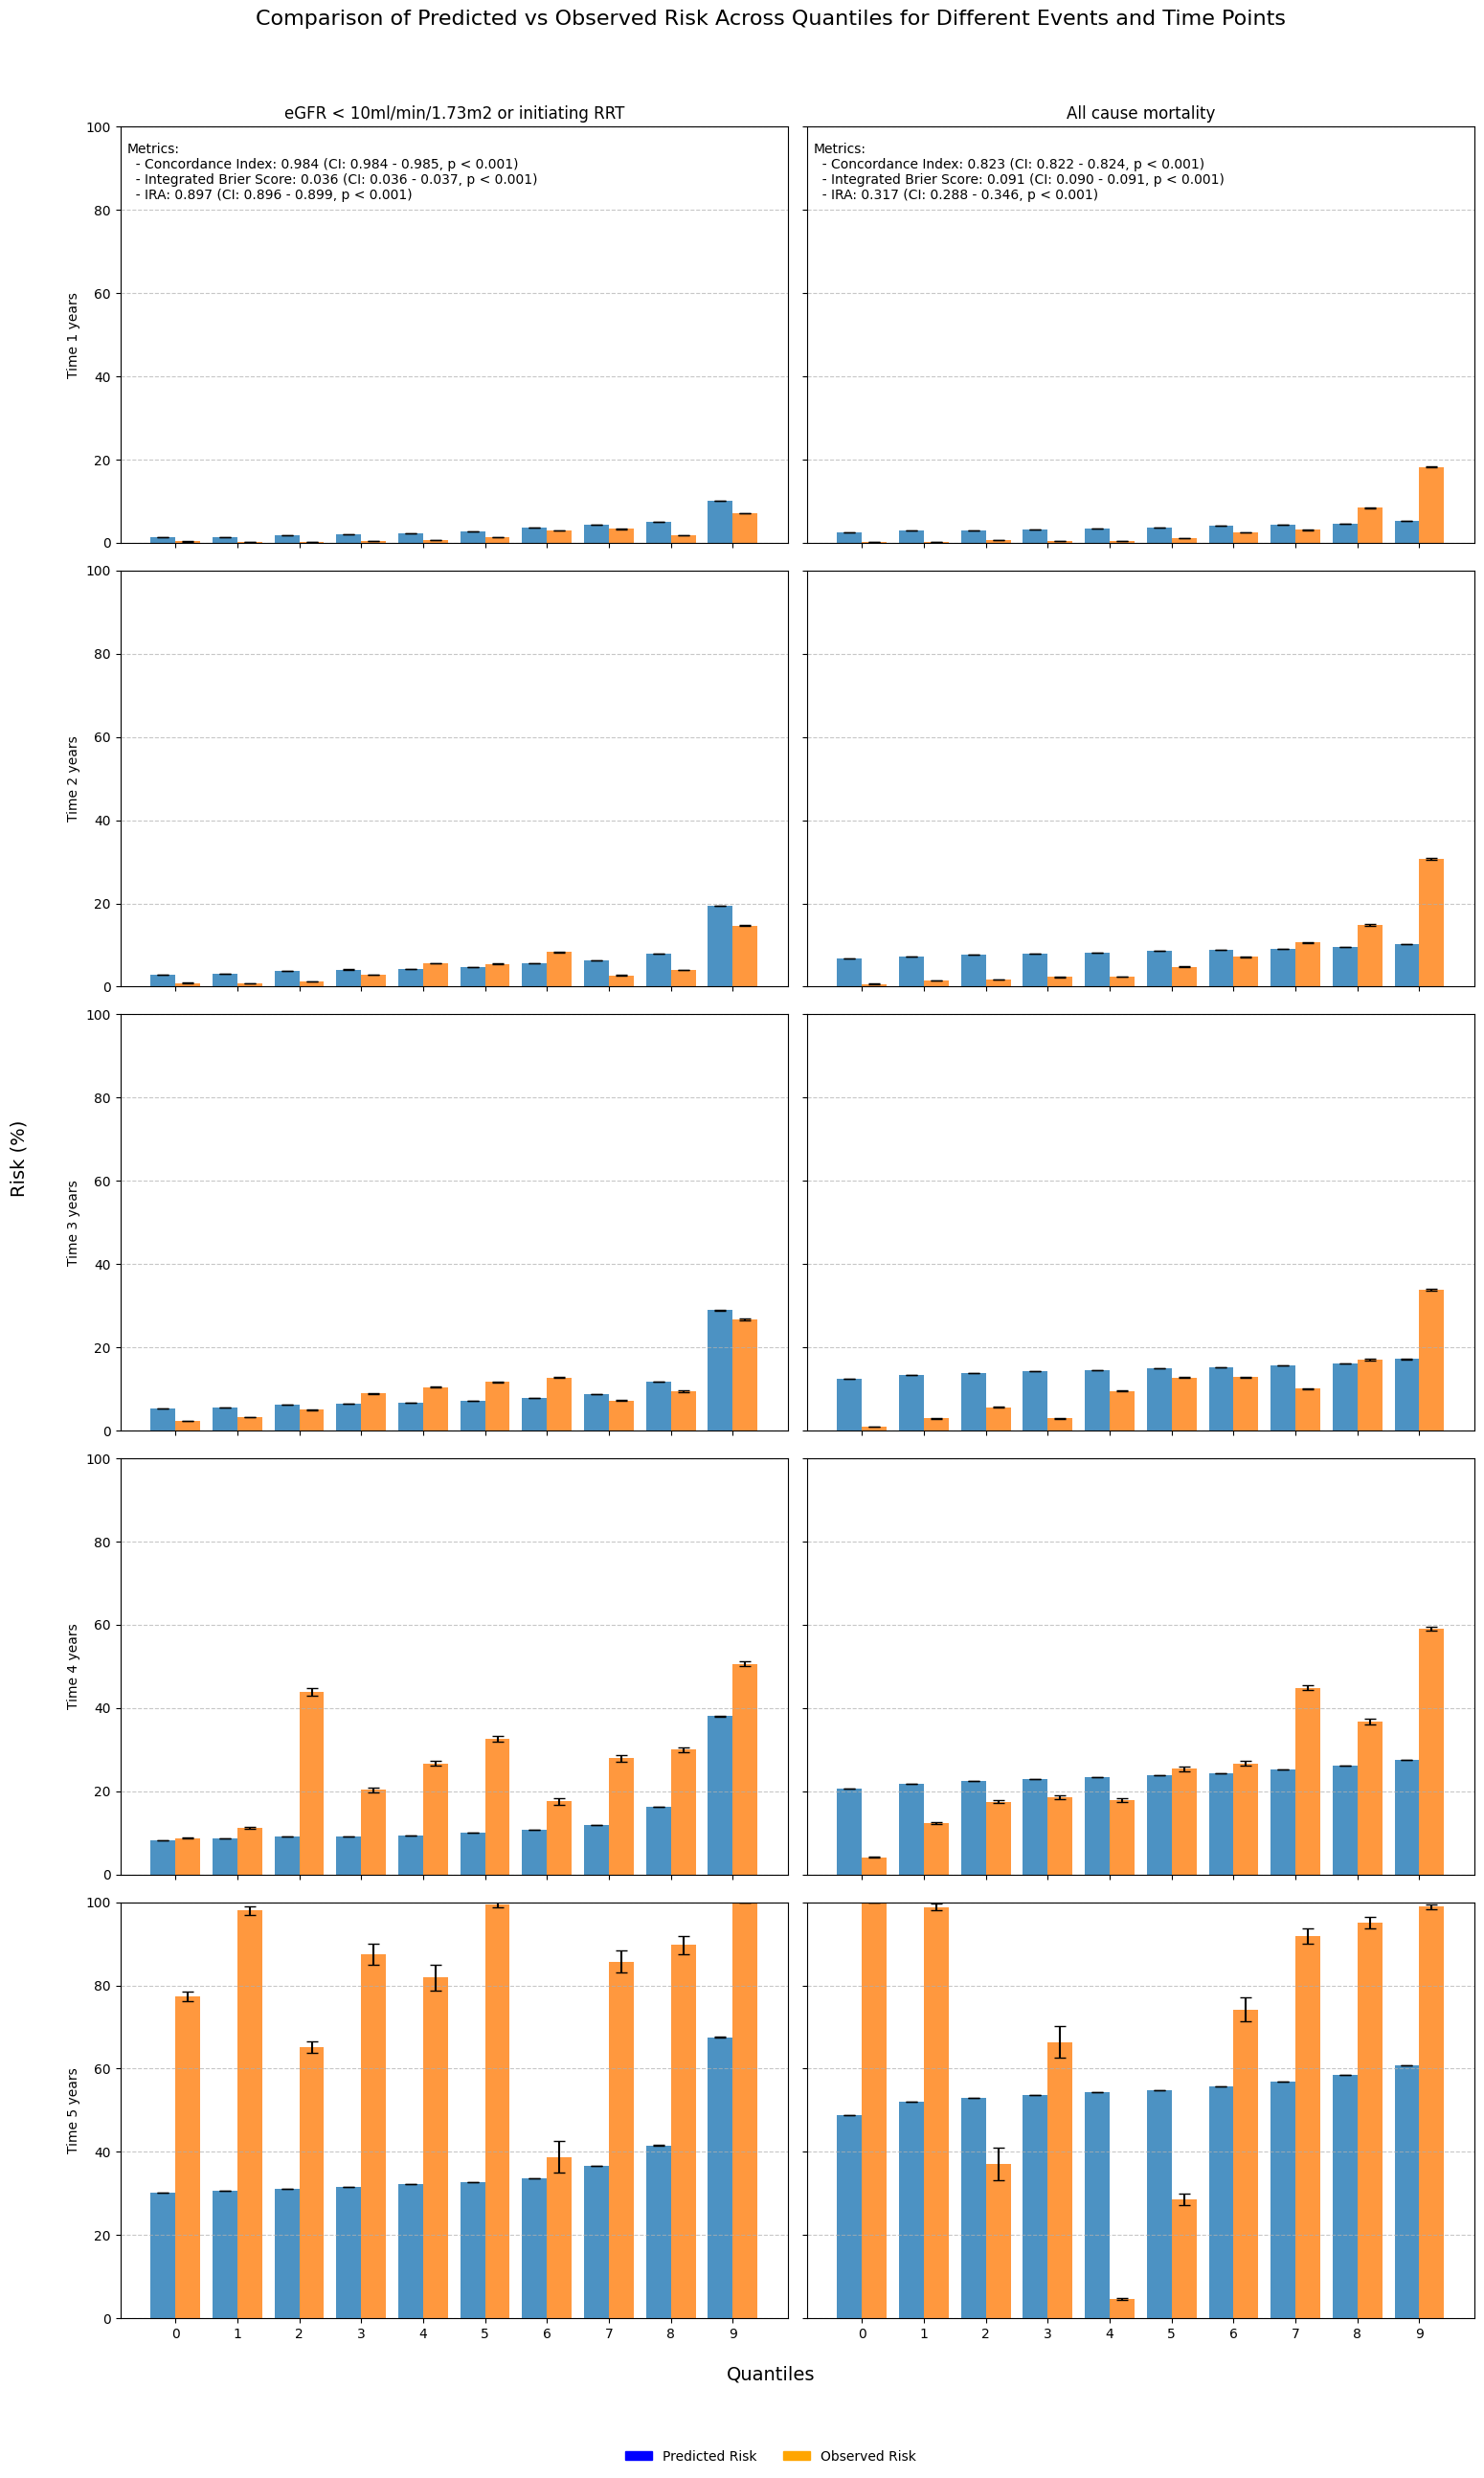

In [279]:
# Setting up subplots
fig, axes = plt.subplots(5, 2, figsize=(15, 25), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.3, wspace=0.1)

# Filtering out time point 0
time_points = sorted(risk_plot_df['Time Point'].unique())[1:]  # Skip time point 0
events = sorted(risk_plot_df['event'].unique())

# Iterating through events and time points
for row, time_point in enumerate(time_points):
    for col, event in enumerate(events):
        ax = axes[row, col]
        
        # Subset the data
        subset = aggregated_df[(aggregated_df['Time Point'] == time_point) & (aggregated_df['event'] == event)]
        
        # Prepare bar data
        quantiles = subset['Quantile']
        predicted_means = subset['Predicted Mean']
        observed_means = subset['Observed Mean']
        predicted_ci = (subset['Predicted Upper CI'] - subset['Predicted Mean']).abs()
        observed_ci = (subset['Observed Upper CI'] - subset['Observed Mean']).abs()
        
        # Bar width
        bar_width = 0.4
        x = np.arange(len(quantiles))
        
        # Plot bars
        ax.bar(x - bar_width/2, predicted_means, width=bar_width, yerr=predicted_ci, capsize=4, label='Predicted', alpha=0.8)
        ax.bar(x + bar_width/2, observed_means, width=bar_width, yerr=observed_ci, capsize=4, label='Observed', alpha=0.8)
        
        ax.grid(axis='y', linestyle='--', alpha=0.7)        
        # Set labels for each subplot
        if row == 0:
            if event == 1:
                ax.set_title(f'eGFR < 10ml/min/1.73m2 or initiating RRT')
            elif event == 2:
                ax.set_title(f'All cause mortality')
        if col == 0:
            ax.set_ylabel(f'Time {time_point} years')

        # Set x-axis quantile labels
        ax.set_xticks(x)
        ax.set_xticklabels(quantiles)
        ax.set_ylim(0, 100)

# Global x and y labels
fig.text(0.5, -0.01, 'Quantiles', ha='center', fontsize=14)
fig.text(-0.03, 0.5, 'Risk (%)', va='center', rotation='vertical', fontsize=14)
fig.suptitle(
    "Comparison of Predicted vs Observed Risk Across Quantiles for Different Events and Time Points",
    fontsize=16,
)

# Define legend elements
predicted_patch = mpatches.Patch(color='blue', label='Predicted Risk')
observed_patch = mpatches.Patch(color='orange', label='Observed Risk')

# Add the legend below the grid of subplots
fig.legend(
    handles=[predicted_patch, observed_patch],
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),  # Position below the subplots
    ncol=2,
    frameon=False
)

event_1_metrics = """
Metrics:
  - Concordance Index: 0.984 (CI: 0.984 - 0.985, p < 0.001)
  - Integrated Brier Score: 0.036 (CI: 0.036 - 0.037, p < 0.001)
  - IRA: 0.897 (CI: 0.896 - 0.899, p < 0.001)
"""
event_2_metrics = """
Metrics:
  - Concordance Index: 0.823 (CI: 0.822 - 0.824, p < 0.001)
  - Integrated Brier Score: 0.091 (CI: 0.090 - 0.091, p < 0.001)
  - IRA: 0.317 (CI: 0.288 - 0.346, p < 0.001)
"""

axes[0, 0].text(
    0.01, 
    1, 
    event_1_metrics, 
    ha='left', 
    va='top', 
    fontsize=10, 
    transform=axes[0, 0].transAxes, 
    wrap=True
)

axes[0, 1].text(
    0.01, 
    1, 
    event_2_metrics, 
    ha='left', 
    va='top', 
    fontsize=10, 
    transform=axes[0, 1].transAxes, 
    wrap=True
)

fig.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
output_path = "/mnt/d/PYDataScience/g3_regress/data/results/9_model_ensemble_risk_comparison.jpeg"
plt.savefig(output_path, format="jpeg", dpi=1000, bbox_inches='tight')
plt.show()
plt.close()


### 5. evaluate effect of ensemlbling models 

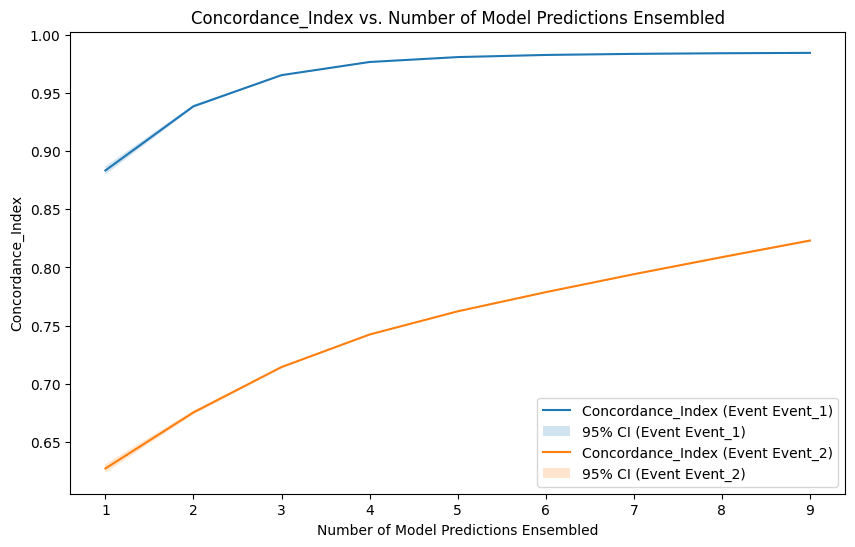

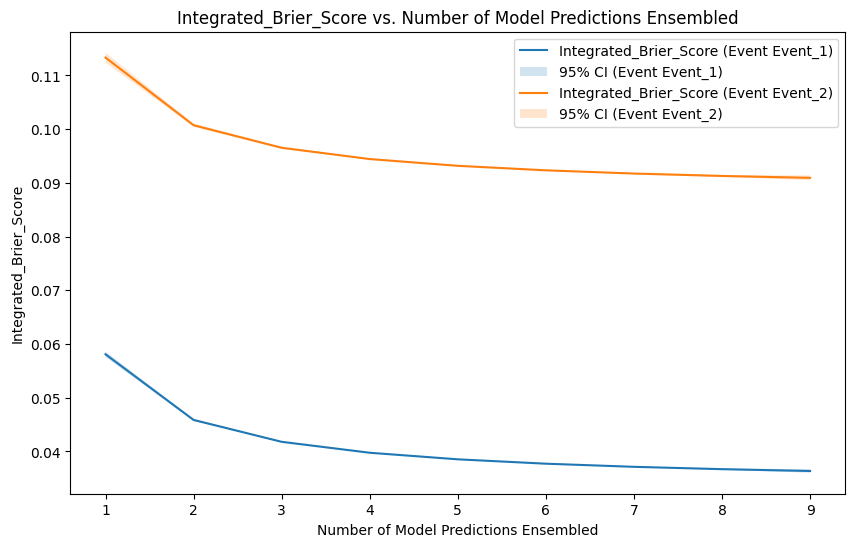

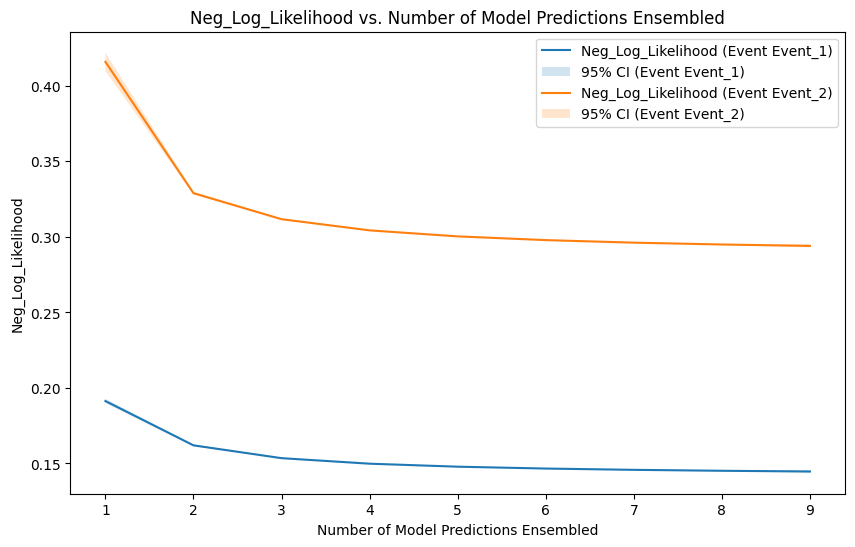

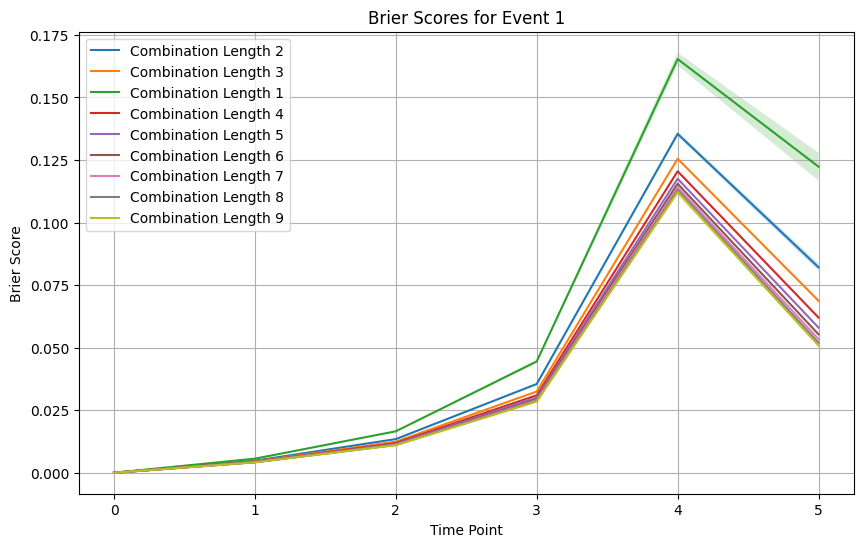

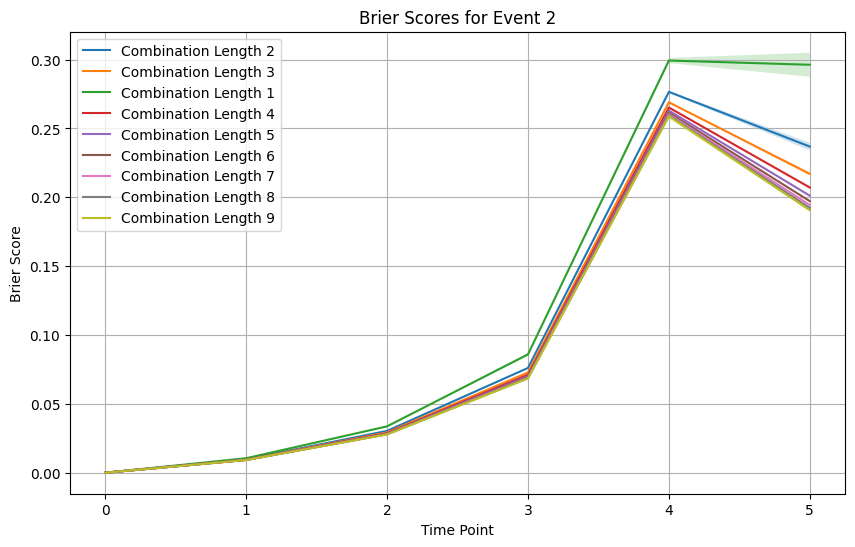

In [140]:

# Call the updated plotting function with the same DataFrame
plot_metric_vs_combination_length(summary_stats_df, metric_name="Concordance_Index")
plot_metric_vs_combination_length(summary_stats_df, metric_name="Integrated_Brier_Score")
plot_metric_vs_combination_length(summary_stats_df, metric_name="Neg_Log_Likelihood")
metrics_df['Combination'] = metrics_df['Combination'].apply(eval)
# Reshape the Brier scores
reshaped_brier_df = reshape_brier_scores(metrics_df)


# Calculate statistics
brier_stats_df = calculate_brier_statistics(reshaped_brier_df)

# Plot the Brier scores
plot_brier_scores(brier_stats_df)